# Stanford CME 241 (Winter 2024) - Assignment 7

**Due: Mar 4 @ 11:59pm Pacific Time on Gradescope (after the exam).**

Assignment instructions:
- **Solve all 3 questions.**
- Empty code blocks are for your use. Feel free to create more under each section as needed.

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):* 

https://github.com/HenriqueMonteiro35/RL-book/blob/master/assignment7.ipynb

*Group members (replace below names with people in your group):*
- Arantxa Ramos del Valle - aramosv
- Henrique Bittencourt Netto Monteiro - hbnm

## Imports

In [15]:
import random
import numpy as np
import itertools
from pprint import pprint
from operator import itemgetter
from numpy.polynomial.laguerre import lagval
from typing import TypeVar, Iterable, Iterator, Callable, Sequence, Tuple, List, Dict, Mapping
import matplotlib.pyplot as plt

from rl.chapter7.asset_alloc_discrete import AssetAllocDiscrete
from rl.chapter3.simple_inventory_mdp_cap import SimpleInventoryMDPCap
from rl.dynamic_programming import value_iteration_result
from rl.approximate_dynamic_programming import ValueFunctionApprox, extended_vf
from rl.policy import FiniteDeterministicPolicy
from rl.function_approx import Tabular, DNNSpec, DNNApprox
from rl.distribution import Choose, Gaussian, SampledDistribution, Categorical
from rl.iterate import converged, last, converge
from rl.monte_carlo import epsilon_greedy_policy
from rl.approximate_dynamic_programming import QValueFunctionApprox, NTStateDistribution
from rl.markov_decision_process import NonTerminal, MarkovDecisionProcess, Policy
from rl.returns import returns
from rl.chapter8.optimal_exercise_bin_tree import OptimalExerciseBinTree
from rl.gen_utils.plot_funcs import plot_list_of_curves
from rl.chapter12.optimal_exercise_rl import training_sim_data, scoring_sim_data, option_price, TrainingDataType
from rl.function_approx import LinearFunctionApprox, Weights, AdamGradient, Gradient
from rl.markov_process import FiniteMarkovRewardProcess, TransitionStep, MarkovRewardProcess

S = TypeVar('S')
A = TypeVar('A')

random.seed(100)
np.random.seed(100)

## Question 1
In the following question, we explore the connection between TD and MC
algorithms.

1.  Implement the TD($\lambda$) Prediction algorithm from scratch in
    Python code. First do it for the Tabular case, then do it for the
    case of Function Approximation.

2.  Prove that the MC Error can be written as the sum of discounted TD
    errors, i.e.,
    $$G_t - V(S_t) = \sum_{u=t}^{T-1} \gamma^{u-t} \cdot (R_{u+1} + \gamma \cdot V(S_{u+1}) - V(S_u))$$
    The goal here is for you to practice formal proof-writing of these
    types of simple yet important identities. So aim to work this out
    from scratch rather than treating this as a special case of a more
    general result proved in class or in the textbook.

3.  Test your above implementation of TD($\lambda$) Prediction algorithm
    by comparing the Value Function of an MRP you have previously
    developed (or worked with) as obtained by Policy Evaluation (DP)
    algorithm, as obtained by MC, as obtained by TD, and as obtained by
    your TD($\lambda$) implementation. Plot graphs of convergence for
    different values of $\lambda$.

4.  Extend `RandomWalkMRP` (in
    [rl/chapter10/random_walk_mrp.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter10/random_walk_mrp.py))
    to `RandomWalkMRP2D` which is a random walk in 2-D with states
    $\{i, j) | 0 \leq i \leq B_1, 0 \leq j \leq B_2\}$ with terminal
    states as $(0, j)$ and $(B_1, j)$ for all $j$, $(i, 0)$ and
    $(i, B_2)$ for all $i$, and with reward of 0 for all $(0, j)$ and
    for all $(i, 0)$, reward of 1 for all $(B_1, j)$ and for all
    $(i, B_2)$, and with discrete probabilities of 4 movements - UP,
    DOWN, LEFT, RIGHT from any non-terminal state. Analyze the
    convergence of MC and TD on this `RandomWalkMRP2D` much like how we
    analyzed it for `RandomWalkMRP`, along with plots of similar graphs.

1. **Answer:**

In [16]:
def td_lambda_tabular(mrp: FiniteMarkovRewardProcess[S],
                      traces: Iterable[Iterable[TransitionStep[S]]],
                      γ: float,
                      lambd: float,
                      initial_vf_map: Mapping[NonTerminal[S], float],
                      learning_rate: float
                     ) -> Iterator[Mapping[NonTerminal[S], float]]:
    
    
    yield initial_vf_map
    val_funct = initial_vf_map
    for trace in traces:
        E: Mapping[NonTerminal[S], int] = {s: 0 for s in mrp.non_terminal_states}
        for tr in trace:
            delta = tr.reward + γ * val_funct[tr.next_state] - val_funct[tr.state] if tr.next_state is NonTerminal else tr.reward - val_funct[tr.state]
            for s in mrp.non_terminal_states:
                E[s] *= γ * lambd
            E[tr.state]+=1
            for s in mrp.non_terminal_states:
                val_funct[s] += learning_rate*(delta) * E[s]
            learning_rate *= 0.99999
            yield val_funct
            

    


def td_lambda_value_approx(mrp: MarkovRewardProcess[S],
                           traces: Iterable[Iterable[TransitionStep]],
                           initial_v_approx: ValueFunctionApprox,
                           γ: float,
                           lambd: float
                          ) -> Iterator[ValueFunctionApprox]:
    yield initial_v_approx
    v_approx = initial_v_approx
    for trace in traces:
        E = Gradient[ValueFunctionApprox[S]] = Gradient(v_approx).zero()
        for tr in trace:
            current_value = v_approx([tr.state])
            next_value = extended_vf(v_approx, tr.next_state) if tr.next_state is not None else 0
            delta = tr.reward + γ * next_value
            E = E * (γ * lambd) + func_approx.objective_gradient(
                xy_vals_seq=[(tr.state, delta)],
                obj_deriv_out_fun=lambda x1, y1: np.ones(len(x1))
                )
            print(v_approx)
            v_approx = v_approx.update_with_gradient(
                E * (v_approx([tr.state]) - delta)
            )
        yield v_approx            
            

2. **Answer:**

Starting with the definition of return:
$$G_t  = \sum_{i=t+1}^{T} \gamma^{i-t-1} \cdot R_{i}=R_{t+1}+\sum_{i=t+2}^{T} \gamma^{i-t-1} \cdot R_{i}=R_{t+1}+\gamma\cdot G_{t+1}$$

We know that the TD error is:
$$\delta_t=R_{t+1}+\gamma\cdot V(S_{t+1})-V(S_{t})$$

Rewritting this as:
$$R_{t+1}= \delta_t-\gamma\cdot V(S_{t+1})+V(S_{t})$$

Therefore, putting the two previous equations together:

$$G_t = \delta_t-\gamma\cdot V(S_{t+1})+V(S_{t})+\gamma\cdot G_{t+1}\Rightarrow G_t -V(S_{t})= \delta_t+\gamma(G_{t+1}- V(S_{t+1}))$$
By doing the same process iteratively: 
$$G_t -V(S_{t})= \delta_t+\gamma(\delta_{t+1}+\gamma(\delta_{t+2}+\gamma(G_{t+3}- V(S_{t+3}))))=  \delta_t+\gamma\delta_{t+1}+\gamma^2\delta_{t+2}+...$$
Now, we substitute the TD error with its definition in the equation, getting:
$$G_t - V(S_t) = \sum_{u=t}^{T-1} \gamma^{u-t} \cdot (R_{u+1} + \gamma \cdot V(S_{u+1}) - V(S_u))$$

3. **Answer**

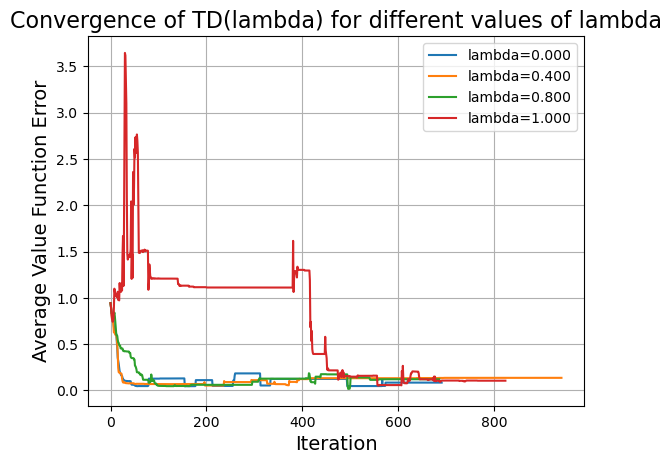

In [17]:
def generate_traces(mrp: FiniteMarkovRewardProcess, num_traces: int) -> Iterable[Iterable[TransitionStep]]:
    initial_states_distribution = Choose(list(mrp.non_terminal_states))
    for _ in range(num_traces):
        yield mrp.simulate_reward(initial_states_distribution)

from  rl.chapter10.random_walk_mrp import RandomWalkMRP
random_walk: RandomWalkMRP = RandomWalkMRP(
    barrier=10,
    p=0.3
)

γ = 0.9
errors_by_lambda = []  
true_vf = random_walk.get_value_function_vec(γ)
learning_rate = 0.5
lambda_values = [0, 0.4, 0.8, 1]

for lambd in lambda_values:
    error_over_time=[]
    traces = generate_traces(random_walk,70)
    initial_vf_map={s: 1.0 for s in random_walk.non_terminal_states}
    vf_estimates = td_lambda_tabular(random_walk, traces, γ, lambd, initial_vf_map, learning_rate)
    vf = next(vf_estimates,None)
    while vf:
        errors = np.sqrt(sum((vf[s] - true_vf[j]) ** 2 for j,s in enumerate(random_walk.non_terminal_states)) / len(random_walk.non_terminal_states))
        error_over_time.append(errors)
        vf = next(vf_estimates,None)
        
    plt.plot(error_over_time, label = f"lambda={lambd:.3f}")
plt.ylabel('Average Value Function Error', fontsize=14)
plt.title(f'Convergence of TD(lambda) for different values of lambda', fontsize=16)
plt.xlabel("Iteration", fontsize=14)
plt.grid(True)
plt.legend(fontsize=10)

plt.show()
        


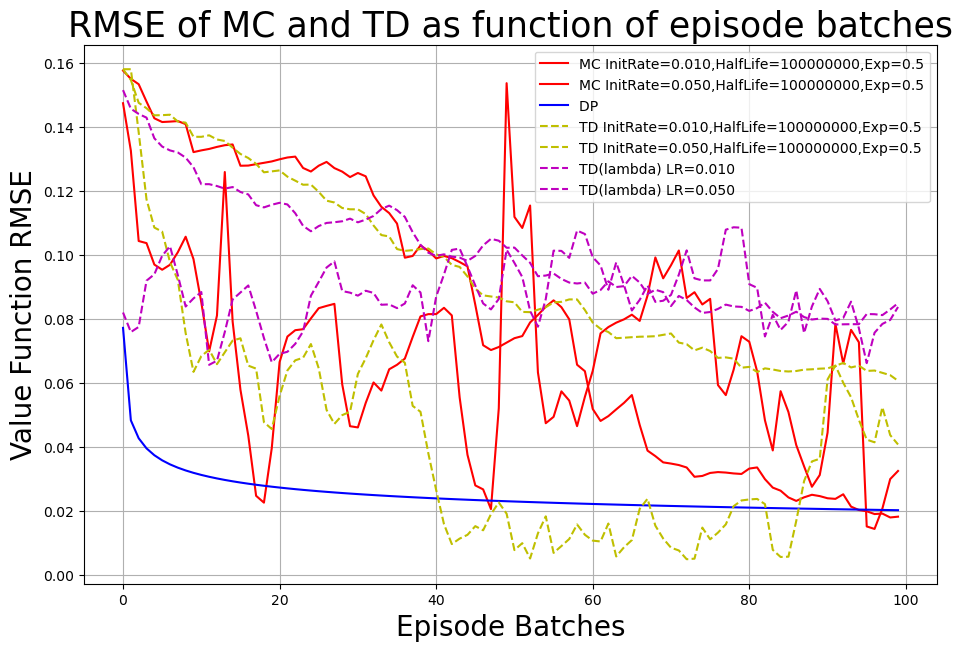

In [18]:
from rl.chapter10.prediction_utils import mc_finite_prediction_learning_rate, td_finite_prediction_learning_rate, fmrp_episodes_stream
from rl.approximate_dynamic_programming import evaluate_finite_mrp

def compare_plots(
    fmrp: FiniteMarkovRewardProcess[S],
    gamma: float,
    mc_episode_length_tol: float,
    num_episodes: int,
    learning_rates: Sequence[Tuple[float, float, float]],
    initial_vf_dict: Mapping[NonTerminal[S], float],
    plot_batch: int,
    plot_start: int
) -> None:
    true_vf: np.ndarray = fmrp.get_value_function_vec(gamma)
    states: Sequence[NonTerminal[S]] = fmrp.non_terminal_states

    
    plt.figure(figsize=(11, 7))

    for k, (init_lr, half_life, exponent) in enumerate(learning_rates):
        mc_funcs_it: Iterator[ValueFunctionApprox[S]] = \
            mc_finite_prediction_learning_rate(
                fmrp=fmrp,
                gamma=gamma,
                episode_length_tolerance=mc_episode_length_tol,
                initial_learning_rate=init_lr,
                half_life=half_life,
                exponent=exponent,
                initial_vf_dict=initial_vf_dict
            )
        mc_errors = []
        batch_mc_errs = []
        for i, mc_f in enumerate(itertools.islice(mc_funcs_it, num_episodes)):
            batch_mc_errs.append(np.sqrt(sum(
                (mc_f(s) - true_vf[j]) ** 2 for j, s in enumerate(states)
            ) / len(states)))
            if i % plot_batch == plot_batch - 1:
                mc_errors.append(sum(batch_mc_errs) / plot_batch)
                batch_mc_errs = []
        mc_plot = mc_errors[plot_start:]
        label = f"MC InitRate={init_lr:.3f},HalfLife" + \
            f"={half_life:.0f},Exp={exponent:.1f}"
        plt.plot(
            range(len(mc_plot)),
            mc_plot,
            color='r',
            linestyle='-',
            label=label
        )

    dp_funcs_it: Iterator[ValueFunctionApprox[S]] = \
            evaluate_finite_mrp(
                mrp=fmrp,
                γ=gamma,
                approx_0 =Tabular(values_map=initial_vf_dict)
            )
    dp_errors = []
    batch_dp_errs = []
    for i, dp_f in enumerate(itertools.islice(dp_funcs_it, num_episodes)):
        batch_dp_errs.append(np.sqrt(sum(
            (dp_f(s) - true_vf[j]) ** 2 for j, s in enumerate(states)
        ) / len(states)))
        if i % plot_batch == plot_batch - 1:
            dp_errors.append(sum(batch_dp_errs) / plot_batch)
            batch_dp_errs = []
    dp_plot = dp_errors[plot_start:]
    label = f"DP "
    plt.plot(
        range(len(dp_plot)),
        dp_plot,
        color='b',
        linestyle='-',
        label=label
    )

    sample_episodes: int = 1000
    td_episode_length: int = int(round(sum(
        len(list(returns(
            trace=fmrp.simulate_reward(Choose(states)),
            γ=gamma,
            tolerance=mc_episode_length_tol
        ))) for _ in range(sample_episodes)
    ) / sample_episodes))

    for k, (init_lr, half_life, exponent) in enumerate(learning_rates):
        td_funcs_it: Iterator[ValueFunctionApprox[S]] = \
            td_finite_prediction_learning_rate(
                fmrp=fmrp,
                gamma=gamma,
                episode_length=td_episode_length,
                initial_learning_rate=init_lr,
                half_life=half_life,
                exponent=exponent,
                initial_vf_dict=initial_vf_dict
            )
        td_errors = []
        transitions_batch = plot_batch * td_episode_length
        batch_td_errs = []

        for i, td_f in enumerate(
                itertools.islice(td_funcs_it, num_episodes * td_episode_length)
        ):
            batch_td_errs.append(np.sqrt(sum(
                (td_f(s) - true_vf[j]) ** 2 for j, s in enumerate(states)
            ) / len(states)))
            if i % transitions_batch == transitions_batch - 1:
                td_errors.append(sum(batch_td_errs) / transitions_batch)
                batch_td_errs = []
        td_plot = td_errors[plot_start:]
        label = f"TD InitRate={init_lr:.3f},HalfLife" + \
            f"={half_life:.0f},Exp={exponent:.1f}"
        plt.plot(
            range(len(td_plot)),
            td_plot,
            color='y',
            linestyle='--',
            label=label
        )
    for k, (init_lr, _, _) in enumerate(learning_rates):
        episodes: Iterable[Iterable[TransitionStep[S]]] = generate_traces(fmrp,100000)
        curtailed_episodes: Iterable[Iterable[TransitionStep[S]]] = (itertools.islice(episode, 10) for episode in episodes)
        td_lambda_funcs_it: Iterator[ValueFunctionApprox[S]] = \
            td_lambda_tabular(
                mrp=fmrp,
                traces=curtailed_episodes,
                γ=gamma,
                lambd=0.5,
                initial_vf_map=initial_vf_dict,
                learning_rate=init_lr
            )
    
        td_lambda_errors = []
        transitions_batch = plot_batch * td_episode_length
        batch_td_lambda_errs = []
        vf_map =next(td_lambda_funcs_it,None)
        i = 0
        while vf_map and i<7000:
    
            current_error = np.sqrt(sum(
                (vf_map[s] - true_vf[j])**2 for j, s in enumerate(states)
            ) / len(states))
            batch_td_lambda_errs.append(current_error)
            
            if i % transitions_batch == transitions_batch - 1:
                avg_error = sum(batch_td_lambda_errs) / len(batch_td_lambda_errs)
                td_lambda_errors.append(avg_error)
                batch_td_lambda_errs = []  
            i += 1
            vf_map =next(td_lambda_funcs_it,None)
    
        td_lambda_plot = td_lambda_errors[plot_start:]
        label = f"TD(lambda) LR={init_lr:.3f}"
        plt.plot(
            range(len(td_lambda_plot)),
            td_lambda_plot,
            color='m', 
            linestyle='--',
            label=label
        )

    plt.xlabel("Episode Batches", fontsize=20)
    plt.ylabel("Value Function RMSE", fontsize=20)
    plt.title(
        "RMSE of MC and TD as function of episode batches",
        fontsize=25
    )
    plt.grid(True)
    plt.legend(fontsize=10)
    plt.show()
    

from  rl.chapter10.random_walk_mrp import RandomWalkMRP
random_walk: RandomWalkMRP = RandomWalkMRP(
    barrier=10,
    p=0.3
)
compare_plots(
    fmrp=random_walk,
    gamma=1.0,
    mc_episode_length_tol=1e-6,
    num_episodes=700,
    learning_rates=[(0.01, 1e8, 0.5), (0.05, 1e8, 0.5)],
    initial_vf_dict={s: 0.0 for s in random_walk.non_terminal_states},
    plot_batch=7,
    plot_start=0
)

4. **Answer:**

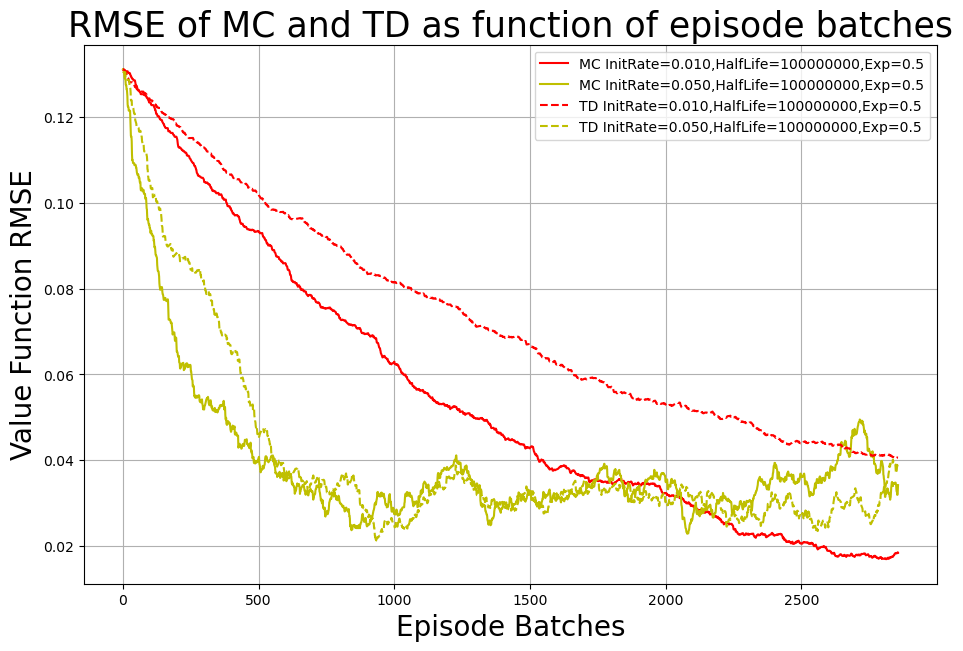

In [19]:
class RandomWalkMRP2D(FiniteMarkovRewardProcess[Tuple[int,int]]):
 
    barrier1: int
    barrier2: int


    def __init__(
        self,
        barrier1: int,
        barrier2: float
    ):
        self.barrier1 = barrier1
        self.barrier2 = barrier2
        super().__init__(self.get_transition_map())

    def get_transition_map(self) -> \
            Mapping[Tuple[int,int], Categorical[Tuple[Tuple[int, int], float]]]:
        d: Dict[Tuple(int,int), Categorical[Tuple[Tuple[int, int], float]]] = {}
        for i in range(1, self.barrier1):
            for j in range(1, self.barrier2):
                state_probs: Dict[Tuple[Tuple[int, int], float], float] = {
                    ((i, j + 1), 1 if j + 1 == self.barrier2 else 0): 0.25,
                    ((i, j - 1, 0), 0): 0.25,
                    ((i + 1, self.barrier1, j), 1 if i + 1 == self.barrier1 else 0): 0.25,
                    ((i - 1, 0, j), 0): 0.25
            }
                d[(i, j)] = Categorical(state_probs)
        return d


from rl.chapter10.prediction_utils import compare_td_and_mc

this_barrier1: int = 10
this_barrier2: int =15
random_walk: RandomWalkMRP2D = RandomWalkMRP2D(
    barrier1=this_barrier1,
    barrier2=this_barrier2
)
compare_td_and_mc(
    fmrp=random_walk,
    gamma=0.9,
    mc_episode_length_tol=1e-6,
    num_episodes=20000,
    learning_rates=[(0.01, 1e8, 0.5), (0.05, 1e8, 0.5)],
    initial_vf_dict={s: 0.0 for s in random_walk.non_terminal_states},
    plot_batch=7,
    plot_start=0
)

## Question 2
In this question, we will explore three different algorithms for control
based on MC or TD. Please complete 2 of the following 3 implementations.
For each algorithm, we expect you to test your implementation against
the Optimal Value Function/Optimal Policy obtained by DP on
`SimpleInventoryMDPCap` in
[rl/chapter3/simple_inventory_mdp_cap.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter3/simple_inventory_mdp_cap.py).
Then, generalize to MC Control with Function approximation and test your
implementation against the Optimal Value Function/Optimal Policy
obtained by ADP on `AssetAllocDiscrete` in
[rl/chapter7/asset_alloc_discrete.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter7/asset_alloc_discrete.py).

1.  Implement Tabular Monte-Carlo Control algorithm in Python with GLIE
    implemented as $\epsilon = \frac 1 k$ for episode number $k$ and
    initial state of each episode sampled uniformly from the state
    space.

2.  Implement Tabular SARSA algorithm in Python with GLIE and a
    parameterized trajectory of decreasing step sizes.

3.  Implement Tabular Q-Learning algorithm in Python with infinite
    exploration of all (state, action) pairs and with a parameterized
    trajectory of decreasing step sizes.

## Helper functions

In [31]:
"""
It is definitely very good coding practice to create in a codebase two similar yet incompatible objects with the
exact same name such as 'TransitionStep' here, so we need to take steps here to avoid this confusion.
"""
del TransitionStep
from rl.markov_decision_process import TransitionStep

def convergence_criteria(x, y, eps):
    x_values = np.array(list(x.values_map.values()))
    y_values = np.array(list(y.values_map.values()))
    if np.linalg.norm(x_values - y_values, ord=2) < eps:
        return True
    return False

def get_vf_and_policy_from_qvf(mdp, qvf):
    opt_vf = {s: max(qvf((s, a)) for a in mdp.actions(s)) for s in mdp.non_terminal_states }
    opt_policy = FiniteDeterministicPolicy({
        s.state: qvf.argmax((s, a) for a in mdp.actions(s))[1] for s in mdp.non_terminal_states
    })
    return opt_vf, opt_policy

## Simple inventory MDP

In [32]:
gamma = 0.9

capacity = 2
poisson_lambda = 1.0
holding_cost = 1.0
stockout_cost = 10.0

mdp = SimpleInventoryMDPCap(
    capacity=capacity,
    poisson_lambda=poisson_lambda,
    holding_cost=holding_cost,
    stockout_cost=stockout_cost
)

print("MDP Value Iteration Optimal Value Function and Optimal Policy")
print("--------------")
opt_vf_vi, opt_policy_vi = value_iteration_result(mdp, gamma=gamma)
pprint(opt_vf_vi)
print(opt_policy_vi)
print()

MDP Value Iteration Optimal Value Function and Optimal Policy
--------------
{NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -37.3284904356655,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -37.97111179441265,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -38.3284904356655,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -38.97111179441265,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -39.3284904356655,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -43.59563313047815}
For State InventoryState(on_hand=0, on_order=0): Do Action 2
For State InventoryState(on_hand=0, on_order=1): Do Action 1
For State InventoryState(on_hand=0, on_order=2): Do Action 0
For State InventoryState(on_hand=1, on_order=0): Do Action 1
For State InventoryState(on_hand=1, on_order=1): Do Action 0
For State InventoryState(on_hand=2, on_order=0): Do Action 0




## GLIE Tabular MC Control

In [33]:
def glie_mc_control_uniform_start_one_over_k(
    mdp: MarkovDecisionProcess[S, A],
    γ: float,
    episode_length_tol: float = 1e-8
) -> Iterator[QValueFunctionApprox[S, A]]:

    starting_qvf = {(s, a): 0.0 for s in mdp.non_terminal_states for a in mdp.actions(s)}
    states: NTStateDistribution[S] = Choose(mdp.non_terminal_states)

    q: QValueFunctionApprox[S, A] = Tabular(values_map=starting_qvf)
    p: Policy[S, A] = epsilon_greedy_policy(q, mdp, 1.0)
    yield q

    num_episodes: int = 0
    while True:
        trace: Iterable[TransitionStep] = mdp.simulate_actions(states, p)
        num_episodes += 1
        for step in returns(trace, γ, episode_length_tol):
            q = q.update([((step.state, step.action), step.return_)])
        p = epsilon_greedy_policy(q, mdp, (lambda k: 1/k)(num_episodes))
        yield q

In [34]:
mcglie = glie_mc_control_uniform_start_one_over_k(mdp=mdp, γ=gamma, episode_length_tol=1e-8)
qvf = converged(mcglie, lambda x, y: convergence_criteria(x, y, eps=1e-3))
opt_vf, opt_policy = get_vf_and_policy_from_qvf(mdp, qvf)
pprint(opt_vf)
print(opt_policy)

{NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -37.333494181526106,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -37.961753562011424,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -38.27765316376939,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -38.92824065802382,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -39.297640109716696,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -43.59376877759475}
For State InventoryState(on_hand=0, on_order=0): Do Action 2
For State InventoryState(on_hand=0, on_order=1): Do Action 1
For State InventoryState(on_hand=0, on_order=2): Do Action 0
For State InventoryState(on_hand=1, on_order=0): Do Action 1
For State InventoryState(on_hand=1, on_order=1): Do Action 0
For State InventoryState(on_hand=2, on_order=0): Do Action 0



## Tabular Q-learning

In [35]:
def q_learning_tabular_infinite_exploration(
    mdp: MarkovDecisionProcess[S, A],
    epsilon: float,
    γ: float,
    max_episode_length: int
) -> Iterator[QValueFunctionApprox[S, A]]:

    assert(epsilon > 0.0)
    policy_from_q = lambda q, mdp: epsilon_greedy_policy(q=q, mdp=mdp, ϵ=epsilon)
    starting_qvf = {(s, a): 0.0 for s in mdp.non_terminal_states for a in mdp.actions(s)}
    states: NTStateDistribution[S] = Choose(mdp.non_terminal_states)

    q: QValueFunctionApprox[S, A] = Tabular(values_map=starting_qvf)
    yield q

    while True:
        state: NonTerminal[S] = states.sample()
        steps: int = 0
        while isinstance(state, NonTerminal) and steps < max_episode_length:
            policy: Policy[S, A] = policy_from_q(q, mdp)
            action: A = policy.act(state).sample()
            next_state, reward = mdp.step(state, action).sample()
            next_return: float = max(
                q((next_state, a)) for a in mdp.actions(next_state)
            ) if isinstance(next_state, NonTerminal) else 0.
            q = q.update([((state, action), reward + γ * next_return)])
            steps += 1
            state = next_state
        yield q

In [36]:
epsilon = 0.1
episode_length = np.log(1e-8)/np.log(gamma)

ql = q_learning_tabular_infinite_exploration(mdp=mdp, epsilon=epsilon, γ=gamma, max_episode_length=episode_length)
qvf = converged(ql, lambda x, y: convergence_criteria(x, y, eps=1e-3))
opt_vf, opt_policy = get_vf_and_policy_from_qvf(mdp, qvf)
pprint(opt_vf)
print(opt_policy)

{NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -26.235886592618773,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -26.609240661483405,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -27.09287529853688,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -27.65234169943594,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -28.153869006089966,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -32.60467193424182}
For State InventoryState(on_hand=0, on_order=0): Do Action 2
For State InventoryState(on_hand=0, on_order=1): Do Action 1
For State InventoryState(on_hand=0, on_order=2): Do Action 0
For State InventoryState(on_hand=1, on_order=0): Do Action 1
For State InventoryState(on_hand=1, on_order=1): Do Action 0
For State InventoryState(on_hand=2, on_order=0): Do Action 0



## Asset Allocation Discrete MDP (warning: book's code takes >20min to run)

In [12]:
steps: int = 4
μ: float = 0.13
σ: float = 0.2
r: float = 0.07
a: float = 1.0
init_wealth: float = 1.0
init_wealth_stdev: float = 0.1

excess: float = μ - r
var: float = σ * σ
base_alloc: float = excess / (a * var)

risky_ret: Sequence[Gaussian] = [Gaussian(μ=μ, σ=σ) for _ in range(steps)]
riskless_ret: Sequence[float] = [r for _ in range(steps)]
utility_function: Callable[[float], float] = lambda x: - np.exp(-a * x) / a
alloc_choices: Sequence[float] = np.linspace(
    2 / 3 * base_alloc,
    4 / 3 * base_alloc,
    11
)
feature_funcs: Sequence[Callable[[Tuple[float, float]], float]] = \
    [
        lambda _: 1.,
        lambda w_x: w_x[0],
        lambda w_x: w_x[1],
        lambda w_x: w_x[1] * w_x[1]
    ]
dnn: DNNSpec = DNNSpec(
    neurons=[],
    bias=False,
    hidden_activation=lambda x: x,
    hidden_activation_deriv=lambda y: np.ones_like(y),
    output_activation=lambda x: - np.sign(a) * np.exp(-x),
    output_activation_deriv=lambda y: -y
)
init_wealth_distr: Gaussian = Gaussian(μ=init_wealth, σ=init_wealth_stdev)

aad: AssetAllocDiscrete = AssetAllocDiscrete(
    risky_return_distributions=risky_ret,
    riskless_returns=riskless_ret,
    utility_func=utility_function,
    risky_alloc_choices=alloc_choices,
    feature_functions=feature_funcs,
    dnn_spec=dnn,
    initial_wealth_distribution=init_wealth_distr
)

In [13]:
it_qvf: Iterator[QValueFunctionApprox[float, float]] = aad.backward_induction_qvf()

print("Backward Induction on Q-Value Function")
print("--------------------------------------")
print()
for t, q in enumerate(it_qvf):
    print(f"Time {t:d}")
    print()
    opt_alloc: float = max(
        ((q((NonTerminal(init_wealth), ac)), ac) for ac in alloc_choices),
        key=itemgetter(0)
    )[1]
    val: float = max(q((NonTerminal(init_wealth), ac))
                        for ac in alloc_choices)
    print(f"Opt Risky Allocation = {opt_alloc:.3f}, Opt Val = {val:.3f}")
    print("Optimal Weights below:")
    for wts in q.weights:
        pprint(wts.weights)
    print()

print("Analytical Solution")
print("-------------------")
print()

for t in range(steps):
    print(f"Time {t:d}")
    print()
    left: int = steps - t
    growth: float = (1 + r) ** (left - 1)
    alloc: float = base_alloc / growth
    vval: float = - np.exp(- excess * excess * left / (2 * var)
                            - a * growth * (1 + r) * init_wealth) / a
    bias_wt: float = excess * excess * (left - 1) / (2 * var) + \
        np.log(np.abs(a))
    w_t_wt: float = a * growth * (1 + r)
    x_t_wt: float = a * excess * growth
    x_t2_wt: float = - var * (a * growth) ** 2 / 2

    print(f"Opt Risky Allocation = {alloc:.3f}, Opt Val = {vval:.3f}")
    print(f"Bias Weight = {bias_wt:.3f}")
    print(f"W_t Weight = {w_t_wt:.3f}")
    print(f"x_t Weight = {x_t_wt:.3f}")
    print(f"x_t^2 Weight = {x_t2_wt:.3f}")
    print()

Backward Induction on Q-Value Function
--------------------------------------

Time 0

Opt Risky Allocation = 1.200, Opt Val = -0.225
Optimal Weights below:
array([[ 0.13378222,  1.30913995,  0.07814413, -0.03174699]])

Time 1

Opt Risky Allocation = 1.300, Opt Val = -0.257
Optimal Weights below:
array([[ 0.08322362,  1.22534352,  0.07737199, -0.02902884]])

Time 2

Opt Risky Allocation = 1.400, Opt Val = -0.291
Optimal Weights below:
array([[ 0.05086045,  1.14500479,  0.05683013, -0.02067698]])

Time 3

Opt Risky Allocation = 1.500, Opt Val = -0.328
Optimal Weights below:
array([[-0.00291341,  1.06976736,  0.06341831, -0.02080102]])

Analytical Solution
-------------------

Time 0

Opt Risky Allocation = 1.224, Opt Val = -0.225
Bias Weight = 0.135
W_t Weight = 1.311
x_t Weight = 0.074
x_t^2 Weight = -0.030

Time 1

Opt Risky Allocation = 1.310, Opt Val = -0.257
Bias Weight = 0.090
W_t Weight = 1.225
x_t Weight = 0.069
x_t^2 Weight = -0.026

Time 2

Opt Risky Allocation = 1.402, Opt Va

## MC Control with function approximation

In [37]:
from typing import Iterable
from rl.distribution import Distribution
from rl.markov_process import Terminal, NonTerminal, State

class AAD_MDP(MarkovDecisionProcess[float, float]):
    def __init__(self, aad: AssetAllocDiscrete) -> None:
        super().__init__()
        self.aad = aad
        self.time = 0

    def step(self, state: NonTerminal[float], action: float) -> Distribution[Tuple[State[float], float]]:
        if self.time == aad.time_steps():
            return Terminal(aad.time_steps())
        mdp_step: Distribution[Tuple[State[float], float]] = self.aad.get_mdp(self.time).step(state, action)
        self.time += 1
        return mdp_step

    def actions(self, state: NonTerminal[float]) -> Iterable[float]:
        return self.aad.get_mdp(self.time).actions(state)

    def get_states(self) -> SampledDistribution[NonTerminal[float]]:
        return self.aad.get_states_distribution(self.time)

    def reset(self):
        self.time = 0

    def simulate_actions(self, start_states: Distribution[NonTerminal[S]], policies: Iterable[Policy[S, A]]) -> Iterable[TransitionStep[S, A]]:

        state: State[S] = start_states.sample()

        i = 0
        while isinstance(state, NonTerminal):
            policy = policies[0]
            action_distribution = policy.act(state)

            action = action_distribution.sample()
            next_distribution = self.step(state, action)

            next_state, reward = next_distribution.sample()
            yield TransitionStep(state, action, next_state, reward)
            state = next_state
            i += 1

In [38]:
def mc_control_func_approx(
    aad_instance: AssetAllocDiscrete,
    γ: float,
    ϵ_as_func_of_episodes: Callable[[int], float],
    episode_length_tolerance: float = 1e-6
) -> Iterator[QValueFunctionApprox[S, A]]:

    aad_mdp = AAD_MDP(aad_instance)
    states = aad_mdp.get_states()

    q_list = [aad_instance.get_qvf_func_approx() for i in range(aad_instance.time_steps())]
    p_list = [epsilon_greedy_policy(q, aad_mdp, 1.0) for q in q_list]
    yield q_list

    num_episodes: int = 0
    while True:
        aad_mdp.reset()
        trace: Iterable[TransitionStep[S, A]] = aad_mdp.simulate_actions(states, p_list)
        num_episodes += 1
        trace_returns = returns(trace, γ, episode_length_tolerance)
        for i, step in enumerate(trace_returns):
            q_list[i] = q_list[i].update([((step.state, step.action), step.return_)])
            p_list[i] = epsilon_greedy_policy(q_list[i], aad_mdp, ϵ_as_func_of_episodes(num_episodes))
        yield q_list

In [39]:
aad2: AssetAllocDiscrete = AssetAllocDiscrete(
    risky_return_distributions=risky_ret,
    riskless_returns=riskless_ret,
    utility_func=utility_function,
    risky_alloc_choices=alloc_choices,
    feature_functions=feature_funcs,
    dnn_spec=dnn,
    initial_wealth_distribution=init_wealth_distr
)

mc_approx = mc_control_func_approx(
    aad_instance = aad2,
    γ = 1,
    ϵ_as_func_of_episodes = lambda k: 1/np.sqrt(k),
)

In [66]:
for i in range(1_000_000):
    next(mc_approx)

In [67]:
it_qvf2 = next(mc_approx)

print("Backward Induction on Q-Value Function")
print("--------------------------------------")
print()
for t, q in enumerate(it_qvf2):
    print(f"Time {t:d}")
    print()
    opt_alloc: float = max(
        ((q((NonTerminal(init_wealth), ac)), ac) for ac in alloc_choices),
        key=itemgetter(0)
    )[1]
    val: float = max(q((NonTerminal(init_wealth), ac))
                        for ac in alloc_choices)
    print(f"Opt Risky Allocation = {opt_alloc:.3f}, Opt Val = {val:.3f}")
    print("Optimal Weights below:")
    for wts in q.weights:
        pprint(wts.weights)
    print()

Backward Induction on Q-Value Function
--------------------------------------

Time 0

Opt Risky Allocation = 1.000, Opt Val = -0.202
Optimal Weights below:
array([[ 0.09479396,  1.71558003,  0.49823453, -0.70703483]])

Time 1

Opt Risky Allocation = 1.500, Opt Val = -0.086
Optimal Weights below:
array([[-6.52954109,  1.39967467,  9.82748062, -3.18326225]])

Time 2

Opt Risky Allocation = 1.300, Opt Val = -0.181
Optimal Weights below:
array([[-6.74644808,  1.21037157, 10.88519695, -4.08723695]])

Time 3

Opt Risky Allocation = 1.400, Opt Val = -0.135
Optimal Weights below:
array([[-8.02930179,  1.06295247, 12.42690092, -4.30128932]])



## Question 3
Finally, we will explore reinforcment learning algorithms and apply them
to the problem of Amercian options pricing. Implement the following two
algorithms and apply them to the problem of American Options Pricing, as
covered in class. Test by comparing the pricing of American Calls and
Puts against the Binomial Tree implmeentation in
[rl/chapter8/optimal_exercise_bin_tree.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter8/optimal_exercise_bin_tree.py).

1.  LSPI

2.  Deep Q-Learning

## Binomial Tree Solution

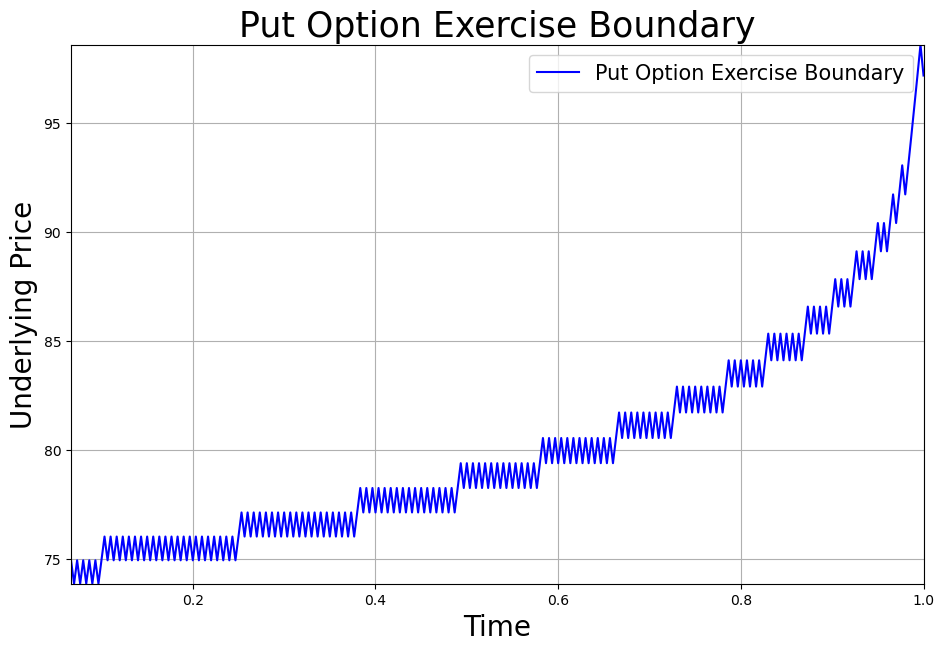

European Price = 7.459
American Price (binary tree) = 7.971


In [68]:
spot_price_val: float = 100.0
strike: float = 100.0
is_call: bool = False
expiry_val: float = 1.0
rate_val: float = 0.05
vol_val: float = 0.25
num_steps_val: int = 300

if is_call:
    opt_payoff = lambda _, x: max(x - strike, 0)
else:
    opt_payoff = lambda _, x: max(strike - x, 0)

opt_ex_bin_tree: OptimalExerciseBinTree = OptimalExerciseBinTree(
    spot_price=spot_price_val,
    payoff=opt_payoff,
    expiry=expiry_val,
    rate=rate_val,
    vol=vol_val,
    num_steps=num_steps_val
)

vf_seq, policy_seq = zip(*opt_ex_bin_tree.get_opt_vf_and_policy())
ex_boundary: Sequence[Tuple[float, float]] = \
    opt_ex_bin_tree.option_exercise_boundary(policy_seq, is_call)
time_pts, ex_bound_pts = zip(*ex_boundary)
label = ("Call" if is_call else "Put") + " Option Exercise Boundary"
plot_list_of_curves(
    list_of_x_vals=[time_pts],
    list_of_y_vals=[ex_bound_pts],
    list_of_colors=["b"],
    list_of_curve_labels=[label],
    x_label="Time",
    y_label="Underlying Price",
    title=label
)

european: float = opt_ex_bin_tree.european_price(is_call, strike)
print(f"European Price = {european:.3f}")

bin_tree_price: float = vf_seq[0][NonTerminal(0)]
print(f"American Price (binary tree) = {bin_tree_price:.3f}")

## LSPI solution

In [74]:
scoring_data: np.ndarray = scoring_sim_data(
    expiry=expiry_val,
    num_steps=100,
    num_paths=10000,
    spot_price=spot_price_val,
    rate=rate_val,
    vol=vol_val
)

In [75]:
def fitted_lspi_put_option(
    expiry: float,
    num_steps: int,
    num_paths: int,
    spot_price: float,
    spot_price_frac: float,
    rate: float,
    vol: float,
    strike: float,
    training_iters: int
) -> LinearFunctionApprox[Tuple[float, float]]:

    num_laguerre: int = 4
    epsilon: float = 1e-3

    ident: np.ndarray = np.eye(num_laguerre)
    features: List[Callable[[Tuple[float, float]], float]] = [lambda _: 1.]
    features += [(lambda t_s, i=i: np.exp(-t_s[1] / (2 * strike)) * lagval(t_s[1] / strike, ident[i])) for i in range(num_laguerre)]
    features += [
        lambda t_s: np.cos(-t_s[0] * np.pi / (2 * expiry)),
        lambda t_s: np.log(expiry - t_s[0]) if t_s[0] != expiry else 0.,
        lambda t_s: (t_s[0] / expiry) ** 2
    ]

    training_data: Sequence[TrainingDataType] = training_sim_data(
        expiry=expiry,
        num_steps=num_steps,
        num_paths=num_paths,
        spot_price=spot_price,
        spot_price_frac=spot_price_frac,
        rate=rate,
        vol=vol
    )

    dt: float = expiry / num_steps
    gamma: float = np.exp(-rate * dt)
    num_features: int = len(features)
    states: Sequence[Tuple[float, float]] = [(i * dt, s) for i, s, _ in training_data]
    next_states: Sequence[Tuple[float, float]] = \
        [((i + 1) * dt, s1) for i, _, s1 in training_data]
    feature_vals: np.ndarray = np.array([[f(x) for f in features] for x in states])
    next_feature_vals: np.ndarray = np.array([[f(x) for f in features] for x in next_states])
    non_terminal: np.ndarray = np.array([i < num_steps - 1 for i, _, _ in training_data])
    exer: np.ndarray = np.array([max(strike - s1, 0) for _, s1 in next_states])
    wts: np.ndarray = np.zeros(num_features)

    for _ in range(training_iters):
        a_inv: np.ndarray = np.eye(num_features) / epsilon
        b_vec: np.ndarray = np.zeros(num_features)
        cont: np.ndarray = np.dot(next_feature_vals, wts)
        cont_cond: np.ndarray = non_terminal * (cont > exer)
        for i in range(len(training_data)):
            phi1: np.ndarray = feature_vals[i]
            phi2: np.ndarray = phi1 - \
                cont_cond[i] * gamma * next_feature_vals[i]
            temp: np.ndarray = a_inv.T.dot(phi2)
            a_inv -= np.outer(a_inv.dot(phi1), temp) / (1 + phi1.dot(temp))
            b_vec += phi1 * (1 - cont_cond[i]) * exer[i] * gamma
        wts = a_inv.dot(b_vec)

    return LinearFunctionApprox.create(
        feature_functions=features,
        weights=Weights.create(wts)
    )

In [76]:
flspi = fitted_lspi_put_option(
    expiry=expiry_val,
    num_steps=20,
    num_paths=1000,
    spot_price=spot_price_val,
    spot_price_frac=0.3,
    rate=rate_val,
    vol=vol_val,
    strike=strike,
    training_iters=8
)

lspi_opt_price = option_price(
    scoring_data=scoring_data,
    func=flspi,
    expiry=expiry_val,
    rate=rate_val,
    strike=strike,
)

print(f"European Put Price = {european:.3f}")
print(f"Binary Tree Price = {bin_tree_price:.3f}")
print(f"LSPI Option Price = {lspi_opt_price:.3f}")

European Put Price = 7.459
Binary Tree Price = 7.971
LSPI Option Price = 7.953


## Deep Q-Learning solution

In [77]:
def fitted_dql_put_option(
    expiry: float,
    num_steps: int,
    num_paths: int,
    spot_price: float,
    spot_price_frac: float,
    rate: float,
    vol: float,
    strike: float,
    training_iters: int
) -> DNNApprox[Tuple[float, float]]:

    reg_coeff: float = 1e-2
    neurons: Sequence[int] = [6]

    num_laguerre: int = 2
    ident: np.ndarray = np.eye(num_laguerre)
    features: List[Callable[[Tuple[float, float]], float]] = [lambda _: 1.]
    features += [(lambda t_s, i=i: np.exp(-t_s[1] / (2 * strike)) * lagval(t_s[1] / strike, ident[i])) for i in range(num_laguerre)]
    features += [
        lambda t_s: np.cos(-t_s[0] * np.pi / (2 * expiry)),
        lambda t_s: np.log(expiry - t_s[0]) if t_s[0] != expiry else 0.,
        lambda t_s: (t_s[0] / expiry) ** 2
    ]

    ds: DNNSpec = DNNSpec(
        neurons=neurons,
        bias=True,
        hidden_activation=lambda x: np.log(1 + np.exp(-x)),
        hidden_activation_deriv=lambda y: np.exp(-y) - 1,
        output_activation=lambda x: x,
        output_activation_deriv=lambda y: np.ones_like(y)
    )

    fa: DNNApprox[Tuple[float, float]] = DNNApprox.create(
        feature_functions=features,
        dnn_spec=ds,
        adam_gradient=AdamGradient(learning_rate=0.1, decay1=0.9, decay2=0.999),
        regularization_coeff=reg_coeff
    )

    dt: float = expiry / num_steps
    gamma: float = np.exp(-rate * dt)
    training_data: Sequence[TrainingDataType] = training_sim_data(
        expiry=expiry,
        num_steps=num_steps,
        num_paths=num_paths,
        spot_price=spot_price,
        spot_price_frac=spot_price_frac,
        rate=rate,
        vol=vol
    )
    for _ in range(training_iters):
        t_ind, s, s1 = training_data[random.randrange(len(training_data))]
        t = t_ind * dt
        x_val: Tuple[float, float] = (t, s)
        val: float = max(strike - s1, 0)
        if t_ind < num_steps - 1:
            val = max(val, fa.evaluate([(t + dt, s1)])[0])
        y_val: float = gamma * val
        fa = fa.update([(x_val, y_val)])
    return fa

In [78]:
fdql = fitted_dql_put_option(
    expiry=expiry_val,
    num_steps=20,
    num_paths=1000,
    spot_price=spot_price_val,
    spot_price_frac=0.02,
    rate=rate_val,
    vol=vol_val,
    strike=strike,
    training_iters=100000
)

dql_opt_price = option_price(
    scoring_data=scoring_data,
    func=fdql,
    expiry=expiry_val,
    rate=rate_val,
    strike=strike,
)

print(f"European Put Price = {european:.3f}")
print(f"Binary Tree Price = {bin_tree_price:.3f}")
print(f"DQL Option Price = {dql_opt_price:.3f}")

European Put Price = 7.459
Binary Tree Price = 7.971
DQL Option Price = 7.936
